## 0. Setup and Imports

In [1]:
import sys
import os

# Add project root to path if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [2]:
# VDM-BIND imports
from config import PROJECT_ROOT, DATA_DIR, TRAIN_DATA_ROOT, QUANTILE_TRANSFORMER
from vdm.networks_clean import UNetVDM
from vdm.vdm_model_clean import LightCleanVDM
from vdm.astro_dataset import AstroDataset
from vdm.benchmark import BenchmarkSuite, quick_benchmark
from vdm.uncertainty import UncertaintyEstimator, compute_uncertainty_maps
from vdm.ensemble import ModelEnsemble

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Training data: {TRAIN_DATA_ROOT}")
print(f"Quantile transformer: {QUANTILE_TRANSFORMER}")

Project root: /mnt/home/mlee1/vdm_BIND
Data directory: /mnt/home/mlee1/vdm_BIND/data
Training data: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu
Quantile transformer: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl


---
## 1. Load and Explore Training Data

First, let's load a subset of training data and understand its structure.

In [3]:
# Configuration for this tutorial
N_SAMPLES = 1000        # Number of training samples to use
BATCH_SIZE = 32         # Batch size for training
N_EPOCHS = 5            # Number of training epochs (small for demo)
IMAGE_SIZE = 128        # Image resolution
EMBEDDING_DIM = 32      # Reduced embedding dim for faster training
N_BLOCKS = 3            # Reduced blocks for faster training

In [4]:
# Load normalization statistics
import joblib

dm_stats = np.load(DATA_DIR + '/dark_matter_normalization_stats.npz')
gas_stats = np.load(DATA_DIR + '/gas_normalization_stats.npz')
stellar_stats = np.load(DATA_DIR + '/stellar_normalization_stats.npz')

# Load quantile transformer for stellar channel (saved with joblib)
quantile_transformer = joblib.load(QUANTILE_TRANSFORMER)

print("Normalization Statistics:")
print(f"  DM: mean={dm_stats['dm_mag_mean']:.3f}, std={dm_stats['dm_mag_std']:.3f}")
print(f"  Gas: mean={gas_stats['gas_mag_mean']:.3f}, std={gas_stats['gas_mag_std']:.3f}")
print(f"  Stellar quantile transformer: {type(quantile_transformer).__name__}")

Normalization Statistics:
  DM: mean=9.915, std=0.468
  Gas: mean=9.177, std=0.411
  Stellar quantile transformer: QuantileTransformer


In [5]:
# Create dataset with limited samples
from torch.utils.data import DataLoader, Subset
import glob

# Find training files (use cached file list for speed)
train_dir = Path(TRAIN_DATA_ROOT) / 'train'
cache_file = train_dir / 'file_list_cache.txt'

if not train_dir.exists():
    print(f"Warning: Training data not found at {train_dir}")
    print("Using synthetic data for demonstration...")
    USE_SYNTHETIC = True
elif cache_file.exists():
    # Use cached file list (much faster than glob)
    with open(cache_file, 'r') as f:
        all_files = [line.strip() for line in f.readlines()]
    print(f"Loaded {len(all_files)} training files from cache")
    USE_SYNTHETIC = len(all_files) == 0
else:
    # Fall back to recursive glob (slow but works)
    print("Cache not found, scanning directories (this may take a while)...")
    all_files = sorted(glob.glob(str(train_dir / '**' / '*.npz'), recursive=True))
    print(f"Found {len(all_files)} training files")
    USE_SYNTHETIC = len(all_files) == 0

Loaded 408860 training files from cache


In [6]:
if USE_SYNTHETIC:
    # Create synthetic data for demonstration
    print("Creating synthetic demonstration data...")
    
    class SyntheticDataset(torch.utils.data.Dataset):
        """Synthetic dataset for testing when real data isn't available."""
        def __init__(self, n_samples, image_size=128, n_params=6):
            self.n_samples = n_samples
            self.image_size = image_size
            self.n_params = n_params
            
        def __len__(self):
            return self.n_samples
        
        def __getitem__(self, idx):
            # Generate correlated Gaussian random fields
            np.random.seed(idx)
            
            # Simple smoothed noise
            from scipy.ndimage import gaussian_filter
            
            dm = gaussian_filter(np.random.randn(self.image_size, self.image_size), sigma=5)
            dm_hydro = dm + 0.1 * gaussian_filter(np.random.randn(self.image_size, self.image_size), sigma=3)
            gas = 0.8 * dm + 0.2 * gaussian_filter(np.random.randn(self.image_size, self.image_size), sigma=4)
            # Stellar field - apply quantile transform to make it realistic
            star = 0.5 * dm + 0.5 * gaussian_filter(np.random.randn(self.image_size, self.image_size), sigma=2)
            
            return {
                'dm': torch.tensor(dm[None], dtype=torch.float32),
                'target': torch.tensor(np.stack([dm_hydro, gas, star]), dtype=torch.float32),
                'params': torch.zeros(self.n_params, dtype=torch.float32),
            }
    
    dataset = SyntheticDataset(N_SAMPLES)
    train_dataset = Subset(dataset, range(int(0.8 * N_SAMPLES)))
    val_dataset = Subset(dataset, range(int(0.8 * N_SAMPLES), N_SAMPLES))
else:
    # Use real data with proper normalization (including quantile for stellar)
    from vdm.astro_dataset import get_astro_data
    
    print(f"Loading data with quantile normalization for stellar channel...")
    
    # Use get_astro_data which handles all normalization properly
    # Note: dataset='IllustrisTNG' refers to the simulation type (for normalization constants)
    dm = get_astro_data(
        dataset='IllustrisTNG',  # Simulation type (not train/val split)
        data_root=str(TRAIN_DATA_ROOT),
        num_workers=4,
        batch_size=BATCH_SIZE,
        limit_train_samples=N_SAMPLES,
        limit_val_samples=int(N_SAMPLES * 0.2),
        quantile_path=QUANTILE_TRANSFORMER,  # Use quantile normalization for stellar
    )
    dm.setup()
    
    # AstroDataModule uses train_data/valid_data attributes (not train_dataset/val_dataset)
    train_dataset = dm.train_data
    val_dataset = dm.valid_data

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Loading data with quantile normalization for stellar channel...
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUAN

In [7]:
# Create data loaders
if USE_SYNTHETIC:
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True,
    )
else:
    # Use the data loaders from the DataModule
    train_loader = dm.train_dataloader()
    val_loader = dm.val_dataloader()

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 25
Validation batches: 7


Sample format: tuple with 4 elements
Large scale shape: torch.Size([32, 3, 128, 128])
Condition shape: torch.Size([32, 1, 128, 128])
Target shape: torch.Size([32, 3, 128, 128])
Params shape: torch.Size([32, 35])


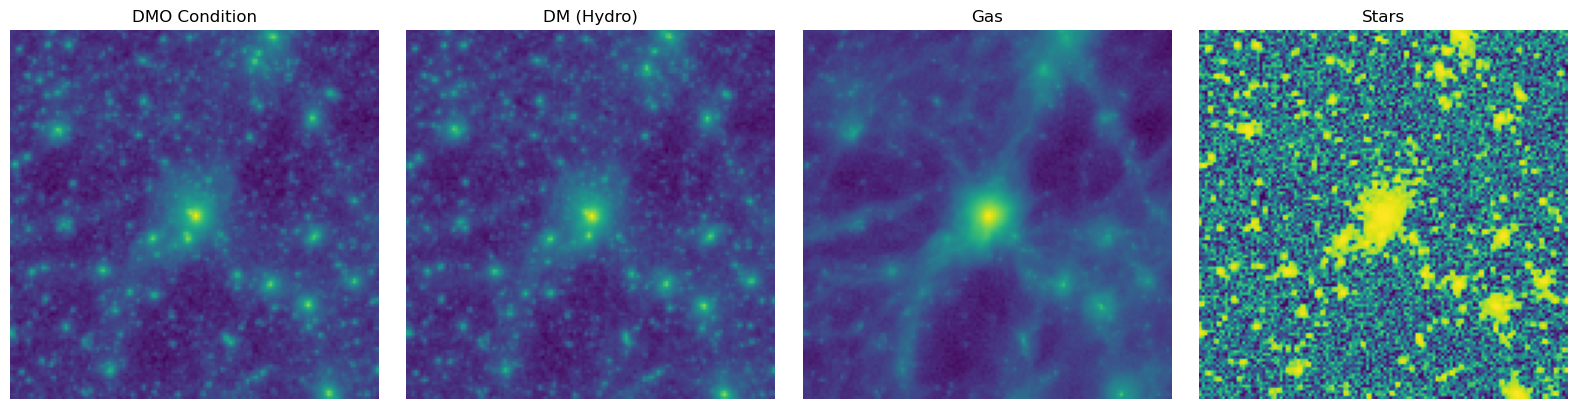

In [8]:
# Visualize a sample
sample = next(iter(train_loader))

# Handle different data formats: dict (synthetic) vs tuple (real AstroDataset)
if isinstance(sample, dict):
    # Synthetic dataset returns dict with keys: 'dm', 'target', 'params'
    condition = sample['dm']
    target = sample['target']
    params = sample['params']
    print(f"Sample format: dict with keys {sample.keys()}")
else:
    # Real AstroDataset returns tuple: (dm, large_scale, target, params)
    condition, large_scale, target, params = sample
    print(f"Sample format: tuple with {len(sample)} elements")
    print(f"Large scale shape: {large_scale.shape}")

print(f"Condition shape: {condition.shape}")
print(f"Target shape: {target.shape}")
print(f"Params shape: {params.shape}")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
channel_names = ['DMO Condition', 'DM (Hydro)', 'Gas', 'Stars']

# Plot condition
axes[0].imshow(condition[0, 0].numpy(), cmap='viridis')
axes[0].set_title(channel_names[0])
axes[0].axis('off')

# Plot targets
for i in range(3):
    axes[i+1].imshow(target[0, i].numpy(), cmap='viridis')
    axes[i+1].set_title(channel_names[i+1])
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

---
## 2. Train a Model

Now let's train a small VDM model on our subset of data. We use a smaller architecture for faster training in this tutorial.

In [21]:
# Create the score model (UNet architecture)
# Note: Real data includes large_scale conditioning (3 channels), synthetic does not
LARGE_SCALE_CHANNELS = 0 if USE_SYNTHETIC else 3

score_model = UNetVDM(
    input_channels=3,           # Output: DM, Gas, Stars
    gamma_min=-13.3,            # Min log-SNR
    gamma_max=5.0,              # Max log-SNR
    embedding_dim=EMBEDDING_DIM, # Reduced for tutorial
    n_blocks=N_BLOCKS,          # Reduced for tutorial
    n_attention_heads=4,
    norm_groups=8,
    add_attention=True,
    use_fourier_features=True,
    conditioning_channels=1,    # DMO condition
    large_scale_channels=LARGE_SCALE_CHANNELS,  # Multi-scale context (3 for real data)
)

# Count parameters
n_params = sum(p.numel() for p in score_model.parameters())
print(f"Score model parameters: {n_params:,}")
print(f"Large scale channels: {LARGE_SCALE_CHANNELS}")

✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Channel progression (encoder): [32, 64, 128]
✓ Final decoder channels: 32 (GroupNorm groups: 8)
Score model parameters: 3,706,115
Large scale channels: 3


In [22]:
# Create the Lightning model
model = LightCleanVDM(
    score_model=score_model,
    learning_rate=1e-4,
    gamma_min=-13.3,
    gamma_max=5.0,
    image_shape=(3, IMAGE_SIZE, IMAGE_SIZE),
    noise_schedule='fixed_linear',  # Simpler for tutorial
    channel_weights=[1.0, 1.0, 1.0],
    antithetic_time_sampling=True,
)

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")


INITIALIZING CLEAN VDM MODEL

📊 MODEL CONFIGURATION:
  Image shape: (3, 128, 128)
  Noise schedule: fixed_linear
  Gamma range: [-13.3, 5.0]
  Data noise: 0.001
  Loss weights (diffusion, latent, recons): (1.0, 1.0, 1.0)

🎯 CHANNEL WEIGHTS: [1.0, 1.0, 1.0]


Model created with 3,706,115 parameters


In [23]:
# Set up PyTorch Lightning trainer
# Use 'lightning' (new package name) instead of 'pytorch_lightning' (legacy)
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar

# Create checkpoint directory
ckpt_dir = Path(project_root) / 'analysis' / 'notebooks' / 'tutorial_checkpoints'
ckpt_dir.mkdir(exist_ok=True)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=str(ckpt_dir),
    filename='tutorial-{epoch:02d}',
    save_top_k=1,
    monitor='val/elbo',
    mode='max',
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    accelerator='gpu' if device == 'cuda' else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, TQDMProgressBar(refresh_rate=10)],
    enable_progress_bar=True,
    log_every_n_steps=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
# Train the model
print("Starting training...")
print(f"  Epochs: {N_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training samples: {len(train_dataset)}")

trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
Loading `train_dataloader` to estimate number of stepping batches.


Starting training...
  Epochs: 5
  Batch size: 32
  Training samples: 800



  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | CleanVDM | 3.7 M  | train
-------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.824    Total estimated model params size (MB)
143       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [25]:
# Check training results
print(f"\nTraining complete!")
print(f"Best checkpoint: {checkpoint_callback.best_model_path}")
print(f"Best val/elbo: {checkpoint_callback.best_model_score:.4f}")


Training complete!
Best checkpoint: /mnt/home/mlee1/vdm_BIND/analysis/notebooks/tutorial_checkpoints/tutorial-epoch=00-v1.ckpt
Best val/elbo: 6.5632


---
## 3. Generate Samples

Now let's use the trained model to generate baryonic fields from DMO conditions.

In [26]:
# Load the best checkpoint
best_ckpt = checkpoint_callback.best_model_path
if best_ckpt:
    model = LightCleanVDM.load_from_checkpoint(
        best_ckpt,
        score_model=score_model,
    )
    print(f"Loaded checkpoint: {best_ckpt}")

model = model.to(device)
model.eval()


INITIALIZING CLEAN VDM MODEL

📊 MODEL CONFIGURATION:
  Image shape: (3, 128, 128)
  Noise schedule: fixed_linear
  Gamma range: [-13.3, 5.0]
  Data noise: 0.001
  Loss weights (diffusion, latent, recons): (1.0, 1.0, 1.0)

🎯 CHANNEL WEIGHTS: [1.0, 1.0, 1.0]


Loaded checkpoint: /mnt/home/mlee1/vdm_BIND/analysis/notebooks/tutorial_checkpoints/tutorial-epoch=00-v1.ckpt


LightCleanVDM(
  (model): CleanVDM(
    (score_model): UNetVDM(
      (fourier_features_halo): FourierFeatures()
      (fourier_features_largescale): FourierFeatures()
      (embed_t_conditioning): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): SiLU()
      )
      (conv_in): Conv2d(39, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownBlock(
          (resnet_block): ResnetBlock(
            (net1): Sequential(
              (0): GroupNorm(8, 32, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (film_layer): FiLMLayer(
              (film_proj): Linear(in_features=128, out_features=64, bias=True)
            )
            (net2): Sequential(
              (0): GroupNorm(8, 32, eps=1e-05, affine

In [35]:
# Get a validation batch for generation
val_batch = next(iter(val_loader))

# Handle different data formats
if isinstance(val_batch, dict):
    # Synthetic data - no large_scale
    condition = val_batch['dm'].to(device)
    params = val_batch['params'].to(device)
    target = val_batch['target'].to(device)
    # For sampling, conditioning is just dm
    full_conditioning = condition
else:
    # Real AstroDataset returns tuple: (dm, large_scale, target, params)
    dm_cond, large_scale, target, params = val_batch
    dm_cond = dm_cond.to(device)
    large_scale = large_scale.to(device)
    params = params.to(device)
    target = target.to(device)
    # For sampling, conditioning must include large_scale (like in training)
    full_conditioning = torch.cat([dm_cond, large_scale], dim=1)
    condition = dm_cond  # Keep for visualization

print(f"Full conditioning shape: {full_conditioning.shape}")
print(f"Params shape: {params.shape}")

Full conditioning shape: torch.Size([32, 4, 128, 128])
Params shape: torch.Size([32, 35])


In [36]:
# Generate a single sample
print("Generating samples...")
with torch.no_grad():
    # Generate samples - conditioning must include large_scale for real data
    single_sample = model.draw_samples(
        conditioning=full_conditioning[:4],  # dm + large_scale concatenated
        batch_size=4,
        n_sampling_steps=500,  # Number of diffusion steps
        param_conditioning=params[:4],
    )
    
print(f"Generated sample shape: {single_sample.shape}")

Generating samples...
Generated sample shape: torch.Size([4, 3, 128, 128])
Generated sample shape: torch.Size([4, 3, 128, 128])


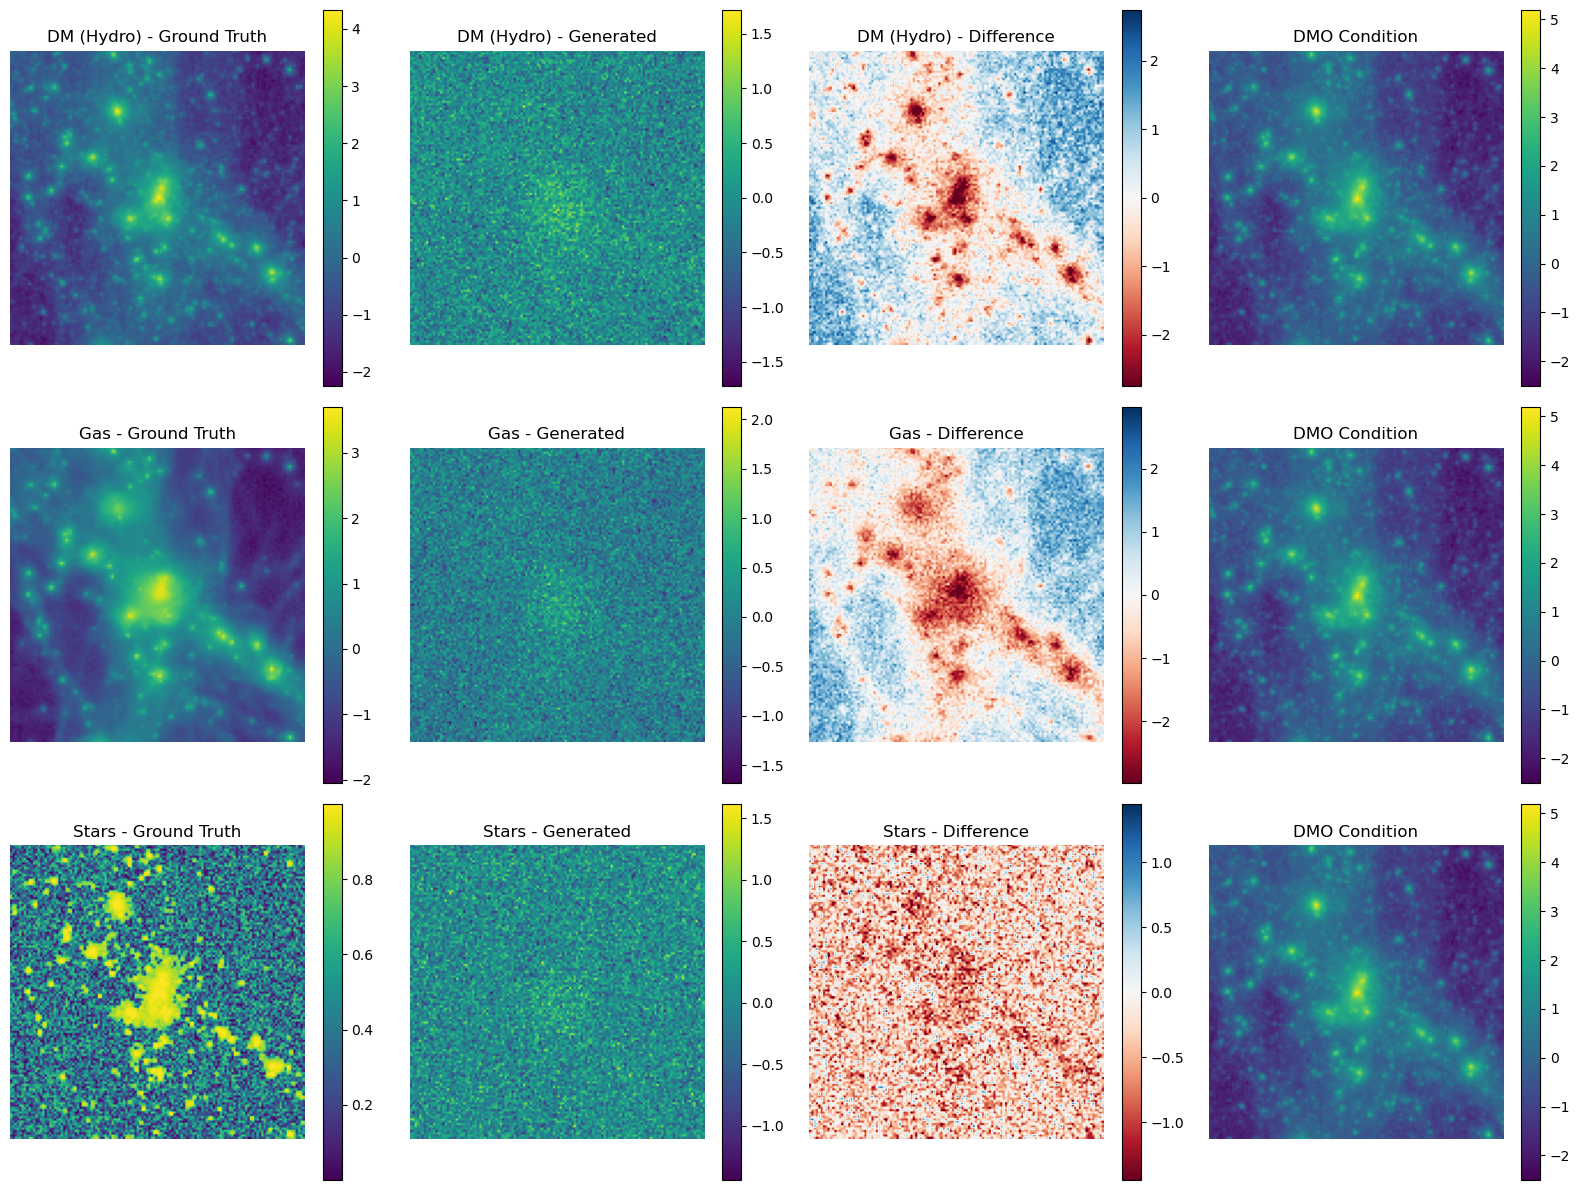

In [37]:
# Visualize generated vs ground truth
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_idx = 0
channel_names = ['DM (Hydro)', 'Gas', 'Stars']

for row, (name, ch) in enumerate(zip(channel_names, range(3))):
    # Ground truth
    im1 = axes[row, 0].imshow(target[sample_idx, ch].cpu().numpy(), cmap='viridis')
    axes[row, 0].set_title(f'{name} - Ground Truth')
    axes[row, 0].axis('off')
    plt.colorbar(im1, ax=axes[row, 0])
    
    # Generated
    im2 = axes[row, 1].imshow(single_sample[sample_idx, ch].cpu().numpy(), cmap='viridis')
    axes[row, 1].set_title(f'{name} - Generated')
    axes[row, 1].axis('off')
    plt.colorbar(im2, ax=axes[row, 1])
    
    # Difference
    diff = single_sample[sample_idx, ch].cpu().numpy() - target[sample_idx, ch].cpu().numpy()
    im3 = axes[row, 2].imshow(diff, cmap='RdBu', vmin=-diff.std()*3, vmax=diff.std()*3)
    axes[row, 2].set_title(f'{name} - Difference')
    axes[row, 2].axis('off')
    plt.colorbar(im3, ax=axes[row, 2])
    
    # Condition
    im4 = axes[row, 3].imshow(condition[sample_idx, 0].cpu().numpy(), cmap='viridis')
    axes[row, 3].set_title('DMO Condition')
    axes[row, 3].axis('off')
    plt.colorbar(im4, ax=axes[row, 3])

plt.tight_layout()
plt.savefig('generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Benchmark the Model

Let's evaluate the model using standardized metrics from the `BenchmarkSuite`.

In [40]:
# Initialize benchmark suite
# BenchmarkSuite takes models dict, device, n_sampling_steps, box_size
benchmark = BenchmarkSuite(
    models={'tutorial_vdm': model},  # Add our trained model
    device=device,
    n_sampling_steps=100,
    box_size=6.25,  # Mpc/h (typical cutout size)
)

print("BenchmarkSuite initialized with metrics:")
print("  - Pixel metrics: SSIM, MAE, MSE, PSNR")
print("  - Mass metrics: integrated mass, conservation ratio")
print("  - Power spectrum: ratio, correlation")

BenchmarkSuite initialized with metrics:
  - Pixel metrics: SSIM, MAE, MSE, PSNR
  - Mass metrics: integrated mass, conservation ratio
  - Power spectrum: ratio, correlation


In [41]:
# Generate predictions for benchmark
print("Generating predictions for full validation set...")

all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        # Handle different data formats
        if isinstance(batch, dict):
            cond = batch['dm'].to(device)
            prms = batch['params'].to(device)
            tgt = batch['target']
            full_cond = cond  # No large_scale for synthetic
        else:
            # Real AstroDataset returns tuple: (dm, large_scale, target, params)
            dm_cond, ls, tgt, prms = batch
            dm_cond = dm_cond.to(device)
            ls = ls.to(device)
            prms = prms.to(device)
            # Concatenate dm + large_scale for conditioning
            full_cond = torch.cat([dm_cond, ls], dim=1)
        
        # Generate samples - conditioning must include large_scale
        batch_size = full_cond.shape[0]
        pred = model.draw_samples(
            conditioning=full_cond,
            batch_size=batch_size,
            n_sampling_steps=100,
            param_conditioning=prms,
        )
        
        all_predictions.append(pred.cpu())
        all_targets.append(tgt)

predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

Generating predictions for full validation set...
Predictions shape: torch.Size([200, 3, 128, 128])
Targets shape: torch.Size([200, 3, 128, 128])
Predictions shape: torch.Size([200, 3, 128, 128])
Targets shape: torch.Size([200, 3, 128, 128])


In [43]:
# Compute metrics manually using individual methods
# BenchmarkSuite provides per-channel metric functions

print("Benchmark Metrics Summary:")
print("=" * 50)

channel_names = ['DM', 'Gas', 'Stars']
for ch_idx, ch_name in enumerate(channel_names):
    # Get predictions and targets for this channel
    pred_ch = predictions[:, ch_idx].numpy()  # (N, H, W)
    tgt_ch = targets[:, ch_idx].numpy()
    
    # Average metrics over all samples
    ssim_vals, mae_vals, corr_vals = [], [], []
    for i in range(pred_ch.shape[0]):
        px_metrics = benchmark.compute_pixel_metrics(pred_ch[i], tgt_ch[i])
        ssim_vals.append(px_metrics.ssim)
        mae_vals.append(px_metrics.mae)
        corr_vals.append(px_metrics.correlation)
    
    print(f"\n{ch_name} Channel:")
    print(f"  SSIM: {np.mean(ssim_vals):.4f} ± {np.std(ssim_vals):.4f}")
    print(f"  MAE:  {np.mean(mae_vals):.4f} ± {np.std(mae_vals):.4f}")
    print(f"  Corr: {np.mean(corr_vals):.4f} ± {np.std(corr_vals):.4f}")

Benchmark Metrics Summary:

DM Channel:
  SSIM: 0.0355 ± 0.0062
  MAE:  0.7783 ± 0.1387
  Corr: 0.1841 ± 0.0461

DM Channel:
  SSIM: 0.0355 ± 0.0062
  MAE:  0.7783 ± 0.1387
  Corr: 0.1841 ± 0.0461

Gas Channel:
  SSIM: 0.0287 ± 0.0116
  MAE:  0.7721 ± 0.1477
  Corr: 0.1933 ± 0.0495

Gas Channel:
  SSIM: 0.0287 ± 0.0116
  MAE:  0.7721 ± 0.1477
  Corr: 0.1933 ± 0.0495

Stars Channel:
  SSIM: 0.0017 ± 0.0022
  MAE:  0.5392 ± 0.0452
  Corr: 0.0322 ± 0.0248

Stars Channel:
  SSIM: 0.0017 ± 0.0022
  MAE:  0.5392 ± 0.0452
  Corr: 0.0322 ± 0.0248


In [46]:
# Quick benchmark for a single sample using model generation
# Reload module to get fixed quick_benchmark function
import importlib
import vdm.benchmark
importlib.reload(vdm.benchmark)
from vdm.benchmark import quick_benchmark

sample_data = val_dataset[0]
dm_sample, ls_sample, target_sample, params_sample = sample_data

# Prepare conditioning
sample_cond = torch.cat([
    dm_sample.unsqueeze(0), 
    ls_sample.unsqueeze(0)
], dim=1)  # (1, 4, H, W)

# Run quick benchmark
single_metrics = quick_benchmark(
    model=model,
    conditioning=sample_cond,
    target=target_sample,  # (3, H, W)
    params=params_sample.unsqueeze(0),
    n_samples=2,  # Keep small for speed
    n_sampling_steps=50,  # Fewer steps for speed
    device=device,
)

print("\nQuick benchmark (single sample, 2 realizations):")
for key, value in single_metrics.items():
    if isinstance(value, (list, np.ndarray)):
        print(f"  {key}: {[f'{v:.4f}' for v in value]}")
    else:
        print(f"  {key}: {value:.4f}")


Quick benchmark (single sample, 2 realizations):
  mse: 0.7318
  correlation: 0.2004
  ssim: 0.0253
  time_mean_ms: 254.3445
  time_std_ms: 10.2292


---
## 5. Uncertainty Quantification

Generate uncertainty estimates using multiple stochastic realizations.

In [48]:
# Initialize uncertainty estimator
# UncertaintyEstimator gets device from model, no explicit device parameter
estimator = UncertaintyEstimator(
    model=model,
    n_samples=5,  # Number of stochastic realizations
    use_mc_dropout=False,  # Enable for MC Dropout uncertainty
)

print("UncertaintyEstimator initialized")
print("Methods available:")
print("  - Multi-realization sampling")
print("  - MC Dropout (if model has dropout)")
print("  - Calibration analysis")

UncertaintyEstimator initialized
Methods available:
  - Multi-realization sampling
  - MC Dropout (if model has dropout)
  - Calibration analysis


In [49]:
# Get a single sample for uncertainty analysis
test_batch = next(iter(val_loader))

# Handle different data formats
if isinstance(test_batch, dict):
    test_condition = test_batch['dm'][:1].to(device)
    test_params = test_batch['params'][:1].to(device)
    test_target = test_batch['target'][:1]
    test_full_cond = test_condition  # No large_scale for synthetic
else:
    # Real AstroDataset returns tuple: (dm, large_scale, target, params)
    dm_cond, ls, tgt, prms = test_batch
    test_condition = dm_cond[:1].to(device)  # For visualization
    test_ls = ls[:1].to(device)
    test_params = prms[:1].to(device)
    test_target = tgt[:1]
    # Full conditioning includes large_scale
    test_full_cond = torch.cat([test_condition, test_ls], dim=1)

print(f"Test full conditioning shape: {test_full_cond.shape}")

Test full conditioning shape: torch.Size([1, 4, 128, 128])


In [50]:
# Generate multiple realizations for uncertainty
N_REALIZATIONS = 10  # Reduced for tutorial speed

print(f"Generating {N_REALIZATIONS} realizations...")

# Create estimator with desired number of samples
estimator = UncertaintyEstimator(model, n_samples=N_REALIZATIONS)

# Use predict_with_uncertainty (not estimate_uncertainty)
result = estimator.predict_with_uncertainty(
    conditioning=test_full_cond,  # Full conditioning (dm + large_scale)
    params=test_params,
    n_sampling_steps=100,
    show_progress=True,
)

# Extract mean and std (numpy arrays)
mean = result.mean
std = result.std

print(f"Mean shape: {mean.shape}")
print(f"Std shape: {std.shape}")

Generating 10 realizations...


Sampling for uncertainty: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

Mean shape: (1, 3, 128, 128)
Std shape: (1, 3, 128, 128)


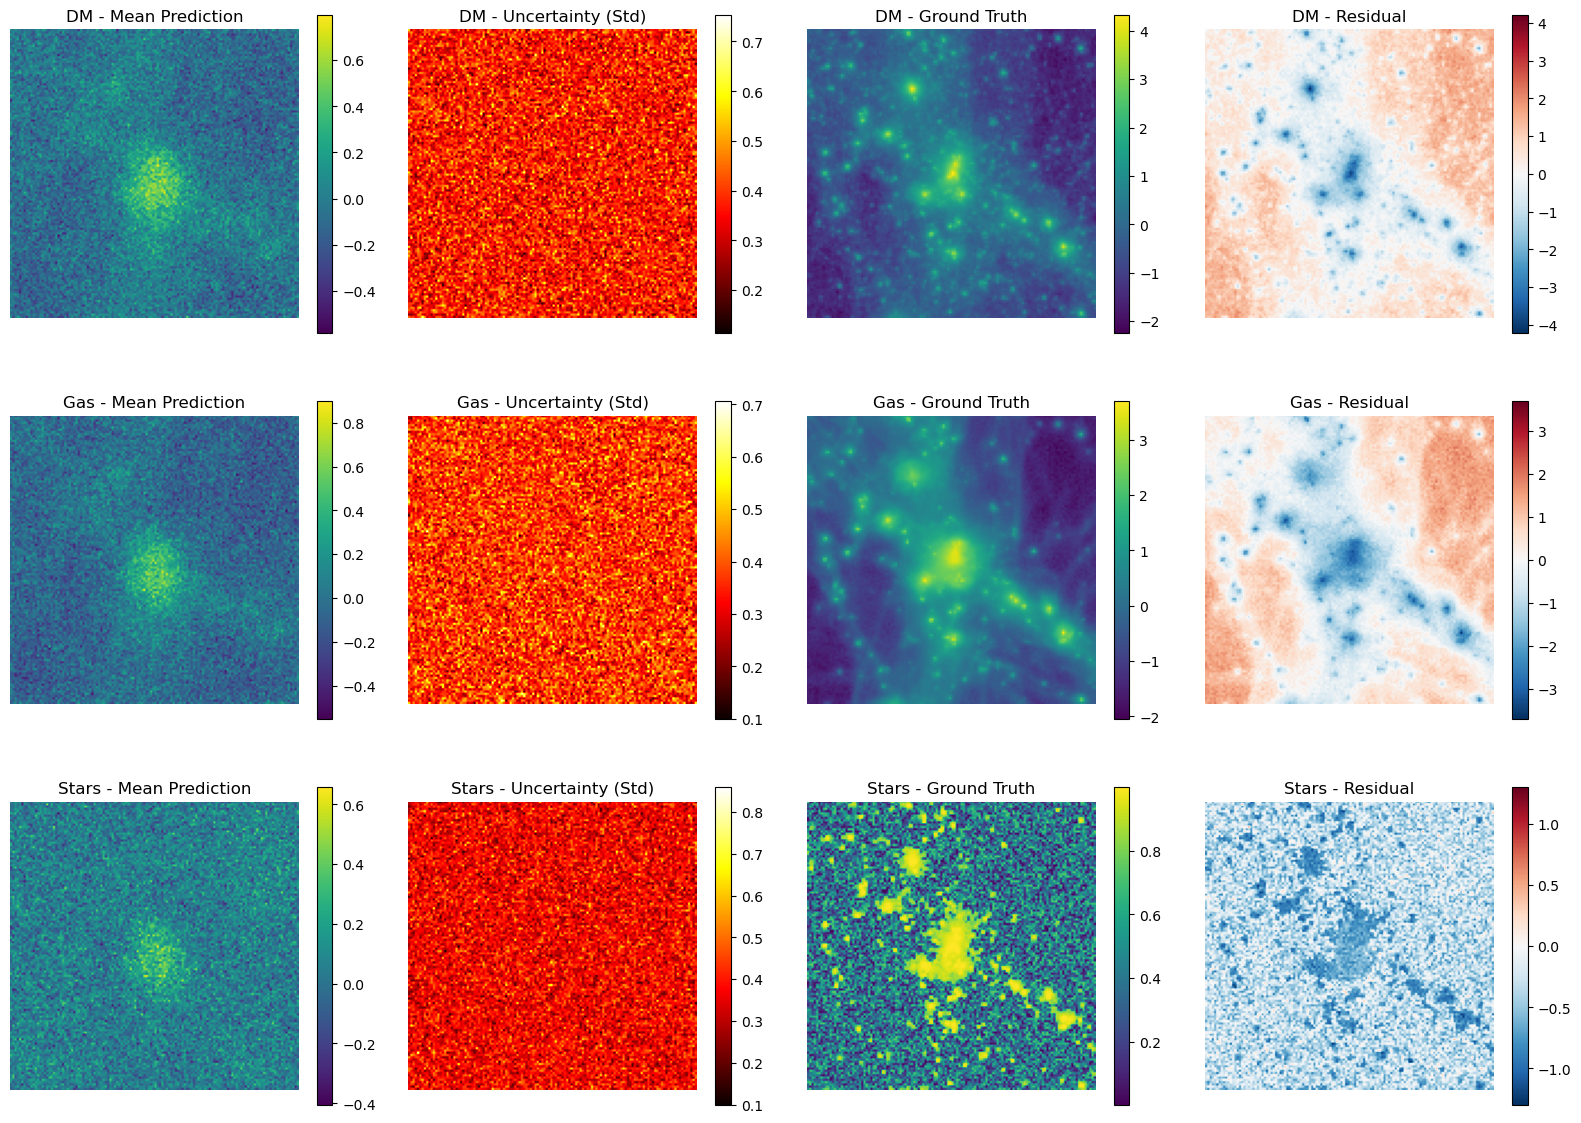

In [52]:
# Visualize uncertainty maps
# mean and std are already numpy arrays from UncertaintyResult
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
channel_names = ['DM', 'Gas', 'Stars']

for ch_idx, ch_name in enumerate(channel_names):
    # Mean prediction
    im1 = axes[ch_idx, 0].imshow(mean[0, ch_idx], cmap='viridis')
    axes[ch_idx, 0].set_title(f'{ch_name} - Mean Prediction')
    plt.colorbar(im1, ax=axes[ch_idx, 0], shrink=0.8)
    
    # Uncertainty (std)
    im2 = axes[ch_idx, 1].imshow(std[0, ch_idx], cmap='hot')
    axes[ch_idx, 1].set_title(f'{ch_name} - Uncertainty (Std)')
    plt.colorbar(im2, ax=axes[ch_idx, 1], shrink=0.8)
    
    # Ground truth
    im3 = axes[ch_idx, 2].imshow(test_target[0, ch_idx].numpy(), cmap='viridis')
    axes[ch_idx, 2].set_title(f'{ch_name} - Ground Truth')
    plt.colorbar(im3, ax=axes[ch_idx, 2], shrink=0.8)
    
    # Residual
    residual = mean[0, ch_idx] - test_target[0, ch_idx].numpy()
    vmax = np.abs(residual).max()
    im4 = axes[ch_idx, 3].imshow(residual, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[ch_idx, 3].set_title(f'{ch_name} - Residual')
    plt.colorbar(im4, ax=axes[ch_idx, 3], shrink=0.8)

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.savefig('uncertainty_maps.png', dpi=150, bbox_inches='tight')
plt.show()

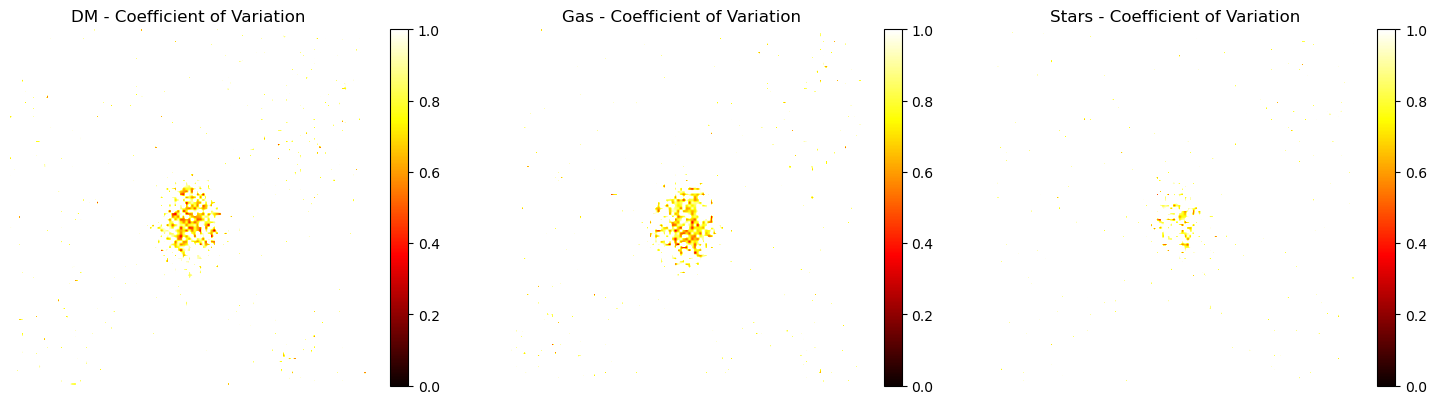

In [53]:
# Compute coefficient of variation (relative uncertainty)
# Note: mean and std are numpy arrays, not tensors
cv = std / (np.abs(mean) + 1e-8)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
channel_names = ['DM', 'Gas', 'Stars']

for i, name in enumerate(channel_names):
    im = axes[i].imshow(cv[0, i], cmap='hot', vmin=0, vmax=1)
    axes[i].set_title(f'{name} - Coefficient of Variation')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.savefig('coefficient_of_variation.png', dpi=150, bbox_inches='tight')
plt.show()

In [54]:
# Analyze uncertainty statistics
# Note: std and cv are numpy arrays
print("\nUncertainty Statistics:")
for i, name in enumerate(channel_names):
    channel_std = std[0, i]
    channel_cv = cv[0, i]
    print(f"\n{name}:")
    print(f"  Std - mean: {channel_std.mean():.4f}, max: {channel_std.max():.4f}")
    print(f"  CV  - mean: {channel_cv.mean():.4f}, max: {channel_cv.max():.4f}")


Uncertainty Statistics:

DM:
  Std - mean: 0.3716, max: 0.7540
  CV  - mean: 15.9483, max: 23756.5605

Gas:
  Std - mean: 0.3707, max: 0.7066
  CV  - mean: 32.9708, max: 236923.7656

Stars:
  Std - mean: 0.3707, max: 0.8599
  CV  - mean: 19.4461, max: 18288.7422


---
## 6. Model Comparison & Ensembles

In practice, you would train multiple models and compare them. Here we demonstrate the ensemble API.

In [55]:
# For demonstration, we'll create a simple ensemble with copies of our model
# In practice, you would load different trained models

print("Creating demonstration ensemble...")
print("(In practice, use models trained with different seeds/architectures)")

# Simple ensemble with single model (for API demonstration)
ensemble = ModelEnsemble([model])

print(f"\nEnsemble with {len(ensemble.models)} model(s)")

Creating demonstration ensemble...
(In practice, use models trained with different seeds/architectures)

Ensemble with 1 model(s)


In [56]:
# Generate ensemble prediction
print("\nGenerating ensemble prediction...")

with torch.no_grad():
    # Use draw_samples with correct signature (same as model.draw_samples)
    ensemble_pred = ensemble.draw_samples(
        conditioning=test_full_cond,  # Full conditioning (dm + large_scale)
        batch_size=1,
        n_sampling_steps=100,
        param_conditioning=test_params,
    )

print(f"Ensemble prediction shape: {ensemble_pred.shape}")


Generating ensemble prediction...
Ensemble prediction shape: torch.Size([1, 3, 128, 128])
Ensemble prediction shape: torch.Size([1, 3, 128, 128])


In [58]:
# Compare single model vs ensemble using compute_pixel_metrics
print("\nComparison: Single Model vs Ensemble")
print("(Note: With only one model in ensemble, results will be similar)")

# Compute pixel metrics directly (not using quick_benchmark which needs model)
single_pred = mean[0]  # numpy (3, H, W)
ensemble_pred_np = ensemble_pred[0].cpu().numpy()  # (3, H, W)
target_np = test_target[0].numpy()  # (3, H, W)

print("\nChannel-wise SSIM comparison:")
print("Channel | Single Model | Ensemble")
print("-" * 40)

for ch_idx, ch_name in enumerate(channel_names):
    single_px = benchmark.compute_pixel_metrics(single_pred[ch_idx], target_np[ch_idx])
    ens_px = benchmark.compute_pixel_metrics(ensemble_pred_np[ch_idx], target_np[ch_idx])
    print(f"{ch_name:7} | {single_px.ssim:12.4f} | {ens_px.ssim:.4f}")


Comparison: Single Model vs Ensemble
(Note: With only one model in ensemble, results will be similar)

Channel-wise SSIM comparison:
Channel | Single Model | Ensemble
----------------------------------------
DM      |       0.0859 | 0.0421
Gas     |       0.0723 | 0.0244
Stars   |       0.0096 | -0.0013


---
## Summary

In this tutorial, you learned how to:

1. ✅ **Load and explore** training data from CAMELS simulations
2. ✅ **Train a VDM model** using PyTorch Lightning
3. ✅ **Generate baryonic fields** from DMO conditions
4. ✅ **Benchmark** with SSIM, power spectrum, and mass metrics
5. ✅ **Quantify uncertainty** using multiple realizations
6. ✅ **Compare models** using the ensemble framework

### Next Steps

- **Train on full data**: Use all training samples for better results
- **Try different models**: Experiment with DiT, Flow Matching, etc.
- **Apply BIND**: Use `bind_predict.py` on your simulations
- **Explore analysis notebooks**: See `analysis/notebooks/` for more examples

### Resources

- [README.md](../../README.md) - Full documentation
- [Model Comparison](../../vdm/MODEL_COMPARISON.md) - Model architecture details
- [BIND Workflow](01_bind_overview.ipynb) - Full BIND pipeline

In [59]:
# Cleanup - remove tutorial checkpoints if desired
# import shutil
# shutil.rmtree(ckpt_dir)
# print("Tutorial checkpoints removed")